In [42]:
import pandas as pd
from utility_functions import cross_validate_and_save_model, vectorize, evaluate,get_confused_samples
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

import matplotlib.pyplot as plt
import random
plt.style.use('dark_background')

# Modify Data
create a modified version of the data that is more balanced and has less samples that are tagged as "no topic"

In [10]:
df = pd.read_csv(f'../data/6 - Classification data/full_classification_df.csv')

df.dropna(subset=['NonStopwordsQuoteText'],inplace=True)
print("total number of samples:",df.shape[0])
print(df['Tag'].value_counts())

total number of samples: 2367
בלי           1035
חינוך          214
קורונה         211
רווחה          191
כלכלי          186
נשים           168
בריאות         161
בטחון פנים     102
בטחון           99
Name: Tag, dtype: int64


In [11]:
df = df.sort_values(by=['Tag']).reset_index(drop=True)
first = df['Tag'].gt("בלי").idxmax()
no_topic_lst = df.index[df['Tag']=="בלי"].tolist()

# drop most samples that are tagged as "no topic" (leave only 200)
first, last = no_topic_lst[0], no_topic_lst[-1]
keep_range = random.sample(range(first, last), 200)
keep_range.extend(range(0,first))
keep_range.extend(range(last + 1, len(df)))

df = df.iloc[keep_range].reset_index(drop=True)
print(df['Tag'].value_counts())
print("total number of samples:",df.shape[0])
df = df.sample(frac=1).reset_index(drop=True)
df.head()

חינוך         214
קורונה        211
בלי           200
רווחה         191
כלכלי         186
נשים          168
בריאות        161
בטחון פנים    102
בטחון          99
Name: Tag, dtype: int64
total number of samples: 1532


,Type,QuoteWordCount,QuoteLen,StartDate,Speaker,QuoteText,NonStopwordsQuoteText,Tag
0,Committee,42.0,264.0,2018-06-06 09:30:00,"היו""ר יעקב מרגי:","בוקר טוב לכולם, אני מתכבד לפתוח את ישיבת ועדת ...",החינוך התרבות והספורט ישיבה משותפת החינוך התרב...,חינוך
1,Committee,38.0,187.0,2018-11-11 10:15:00,"היו""ר נורית קורן:","אז תל השומר, שיבא, שבעצם הוא טיפל בילדים תקופה...",תל השומר שיבא שבעצם טיפל בילדים תקופה ארוכה נו...,בריאות
2,Committee,52.0,290.0,2021-02-08 09:00:00,<< דובר_המשך >> מידן בר: << דובר_המשך >>,עשו אותו לפני המוטציות וגם לשפעת יש עד היום מו...,עשו המוטציות לשפעת מוטציות מוטציות שצריך ללמוד...,בריאות
3,Committee,65.0,327.0,2018-01-31 09:30:00,"היו""ר איתן כבל:","בוקר טוב. בוקר טוב לך, גברתי מנהלת הוועדה, היו...",היועצת המשפטית רשמת חבריי רביעי טו בשבט חגה הה...,בלי
4,Committee,102.0,539.0,2020-09-21 10:30:00,"<< יור >> היו""ר עודד פורר: << יור >>",אני חייב לציין את האירוע המצער שהיה במצפה רמון...,חייב לציין האירוע המצער במצפה רמון קראתי הבוקר...,נשים


## Split data to train and test

In [12]:
X = df['QuoteText']
y = df['Tag']
names = ["X_train", "X_test", "y_train", "y_test"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
for name, data in enumerate([X_train, X_test, y_train, y_test]):
    data.reset_index(drop=True, inplace=True)
    data.to_csv(f'../data/7 - Classification Data (phase 2)/{names[name]}.csv', index=0)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

print("Tags distribution:\n")
print("train tags\n", y_train.value_counts(), "\n")
print("test tags\n", y_test.value_counts())

Tags distribution:

train tags
 חינוך         166
קורונה        165
בלי           163
רווחה         156
כלכלי         146
נשים          133
בריאות        129
בטחון          85
בטחון פנים     82
Name: Tag, dtype: int64 

test tags
 חינוך         48
קורונה        46
כלכלי         40
בלי           37
רווחה         35
נשים          35
בריאות        32
בטחון פנים    20
בטחון         14
Name: Tag, dtype: int64


## Vectorize data

In [13]:
X_train_counts, X_test_counts = vectorize(X_train, X_test,"simple_counts")
X_train_tfidf, X_test_tfidf = vectorize(X_train, X_test,"tfidf")

simple counts: 1225 quotes, 48772 words in train set
TFIDF: 1225 quotes, 48772 words in train set


# Classificaiton models
## Logistic Regression
#### Logistic Regression with simple counts

In [14]:
logistic_simple_model, logistic_simple_predicted = cross_validate_and_save_model(LogisticRegression(), X_train_counts, y_train, X_test_counts, kf, scoring, 'logistic_simple_counts',2)

cross validation scores (5fold) for logistic_simple_counts:
accuracy: 0.5575510204081633
precision_macro: 0.6865964218519256
recall_macro: 0.5249784105105066
f1_macro: 0.553508419923606


In [15]:
logistic_c2_simple_model, logistic_c2_simple_predicted = cross_validate_and_save_model(LogisticRegression(C=2), X_train_counts, y_train, X_test_counts, kf, scoring, 'logistic_c2_simple_counts',2)

cross validation scores (5fold) for logistic_c2_simple_counts:
accuracy: 0.5608163265306122
precision_macro: 0.687897229953911
recall_macro: 0.5288906538590245
f1_macro: 0.5569597800697933


In [16]:
logistic_c05_simple_model, logistic_c05_simple_predicted = cross_validate_and_save_model(LogisticRegression(C=0.5), X_train_counts, y_train, X_test_counts, kf, scoring, 'logistic_c05_simple_counts',2)

cross validation scores (5fold) for logistic_c05_simple_counts:
accuracy: 0.5575510204081633
precision_macro: 0.6910372919606301
recall_macro: 0.524098658024717
f1_macro: 0.5533147273217105


#### Logistic Regression with TFIDF

In [17]:
logistic_tfidf_model, logistic_tfidf_predicted = cross_validate_and_save_model(LogisticRegression(), X_train_tfidf, y_train, X_test_tfidf, kf, scoring, 'logistic_tfidf_counts',2)

cross validation scores (5fold) for logistic_tfidf_counts:
accuracy: 0.49714285714285716
precision_macro: 0.6814808034014843
recall_macro: 0.45667840175074614
f1_macro: 0.4761982353738242


In [18]:
logistic_c05_tfidf_model, logistic_c05_tfidf_predicted = cross_validate_and_save_model(LogisticRegression(C=0.5), X_train_tfidf, y_train, X_test_tfidf, kf, scoring, 'logistic_c05_tfidf_counts',2)

cross validation scores (5fold) for logistic_c05_tfidf_counts:
accuracy: 0.47183673469387755
precision_macro: 0.5734425007386139
recall_macro: 0.42747139593206995
f1_macro: 0.4381750867291805


## Random Forest
#### Random forest with simple counts

In [19]:
forest_30_100_simple_model, forest_30_100_simple_predicted = cross_validate_and_save_model(RandomForestClassifier(n_estimators=30, max_depth=100), X_train_counts, y_train, X_test_counts, kf, scoring, 'forest_30_100_simple_counts',2)

cross validation scores (5fold) for forest_30_100_simple_counts:
accuracy: 0.5493877551020407
precision_macro: 0.654590929170665
recall_macro: 0.5215209136486985
f1_macro: 0.5447765544420463


In [20]:
forest_100_100_simple_model, forest_100_100_simple_predicted = cross_validate_and_save_model(RandomForestClassifier(n_estimators=100, max_depth=100), X_train_counts, y_train, X_test_counts, kf, scoring, 'forest_100_100_simple_counts',2)

cross validation scores (5fold) for forest_100_100_simple_counts:
accuracy: 0.5624489795918367
precision_macro: 0.6884074336852912
recall_macro: 0.540475753895327
f1_macro: 0.5679250603423622


In [21]:
forest_200_100_simple_model, forest_200_100_simple_predicted = cross_validate_and_save_model(RandomForestClassifier(n_estimators=200, max_depth=100), X_train_counts, y_train, X_test_counts, kf, scoring, 'forest_200_100_simple_counts',2)

cross validation scores (5fold) for forest_200_100_simple_counts:
accuracy: 0.5640816326530612
precision_macro: 0.6964588057166864
recall_macro: 0.5416458252194334
f1_macro: 0.5699176676058403


In [22]:
forest_100_200_simple_model, forest_100_200_simple_predicted = cross_validate_and_save_model(RandomForestClassifier(n_estimators=100, max_depth=200), X_train_counts, y_train, X_test_counts, kf, scoring, 'forest_100_200_simple_counts',2)

cross validation scores (5fold) for forest_100_200_simple_counts:
accuracy: 0.5322448979591836
precision_macro: 0.6964142263435706
recall_macro: 0.5072970369172795
f1_macro: 0.5333691932104434


In [23]:
forest_100_1000_simple_model, forest_100_1000_simple_predicted = cross_validate_and_save_model(RandomForestClassifier(n_estimators=100, max_depth=1000), X_train_counts, y_train, X_test_counts, kf, scoring, 'forest_100_1000_simple_counts',2)

cross validation scores (5fold) for forest_100_1000_simple_counts:
accuracy: 0.5020408163265306
precision_macro: 0.7078628376011841
recall_macro: 0.4685315426210891
f1_macro: 0.4989290677860099


In [24]:
forest_150_1000_simple_model, forest_150_1000_simple_predicted = cross_validate_and_save_model(RandomForestClassifier(n_estimators=150, max_depth=1000), X_train_counts, y_train, X_test_counts, kf, scoring, 'forest_150_1000_simple_counts',2)

cross validation scores (5fold) for forest_150_1000_simple_counts:
accuracy: 0.49714285714285716
precision_macro: 0.7153657955912043
recall_macro: 0.46544537619982496
f1_macro: 0.49671872933646427


#### Random forest with TFIDF

In [25]:
forest_100_200_tfidf_model, forest_100_200_tfidf_predicted = cross_validate_and_save_model(RandomForestClassifier(n_estimators=100, max_depth=200), X_train_tfidf, y_train, X_test_tfidf, kf, scoring, 'forest_100_200_tfidf_counts',2)

cross validation scores (5fold) for forest_100_200_tfidf_counts:
accuracy: 0.5404081632653062
precision_macro: 0.7223220977544209
recall_macro: 0.5161577818995566
f1_macro: 0.5500529951374106


In [26]:
forest_100_1000_tfidf_model, forest_100_1000_tfidf_predicted = cross_validate_and_save_model(RandomForestClassifier(n_estimators=100, max_depth=1000), X_train_tfidf, y_train, X_test_tfidf, kf, scoring, 'forest_100_1000_tfidf_counts',2)

cross validation scores (5fold) for forest_100_1000_tfidf_counts:
accuracy: 0.5012244897959184
precision_macro: 0.7407076876815146
recall_macro: 0.4689307659580669
f1_macro: 0.5035898924586106


## SVM
#### SVM with simple counts

In [27]:
svm_simple_model, svm_simple_predicted = cross_validate_and_save_model(svm.SVC(), X_train_counts, y_train, X_test_counts, kf, scoring, 'svm_simple_counts',2)

cross validation scores (5fold) for svm_simple_counts:
accuracy: 0.38448979591836735
precision_macro: 0.5173699524694092
recall_macro: 0.34059045831948226
f1_macro: 0.3487947671573293


#### SVM with TFIDF

In [28]:
svm_tfidf_model, svm_tfidf_predicted = cross_validate_and_save_model(svm.SVC(), X_train_tfidf, y_train, X_test_tfidf, kf, scoring, 'svm_tfidf_counts',2)

cross validation scores (5fold) for svm_tfidf_counts:
accuracy: 0.38775510204081637
precision_macro: 0.6476729688380635
recall_macro: 0.3488189577668514
f1_macro: 0.36420939360197657


# Evaluation

In [29]:
quotes = X_test.reset_index()
quotes['true'] = y_test
mat_tags = ['בטחון','בטחון פנים','בלי','בריאות','חינוך','כלכלי','נשים','קורונה','רווחה']
quotes

,index,QuoteText,true
0,0,"שלום לכולם, שמי יוסי שביט ממרכז טאוב ומאוניברס...",חינוך
1,1,היום הדיון הראשון יתקיים בעניין העברת הטיפול ב...,בריאות
2,2,תודה רבה לכם שבאתם. אנחנו מתשע בבוקר בכל ועדות...,רווחה
3,3,"לגבי תשלומי הורים, גם פה אני חייב להגיד: הוועד...",חינוך
4,4,דבר נוסף שהגיע גם לפתחה של הוועדה זה שאנשים שח...,קורונה
...,...,...,...
302,302,אני מחדש את הישיבה בהצעת חוק סמכויות מיוחדות ל...,קורונה
303,303,"עכשיו, היות וזה תהליך ארוך ומתייחס לתקופות שונ...",בטחון
304,304,\tאני מאוד מבקש שכולנו היום נתגייס מתוך מטרה א...,חינוך
305,305,"אגב, רוב האסירים או אחוז גבוה מתוכם הם עד שלוש...",בטחון פנים


## Logistic regression

-------Logistic Regression simple counts, C=1) Evaluation-------
Micro:
precision: 0.5700325732899023
recall: 0.5700325732899023
f1: 0.5700325732899023

Macro:
precision: 0.6640782397748342
recall: 0.5176033953207866
f1: 0.5464663675789553

Accuracy: 0.5700325732899023

Confusion Matrix:

--------- confusion analysis----------
misclassified as no topic: 84 of 132 (63.63636363636363%)

Distribution of misclassified topics:
בלי           84
בריאות        12
כלכלי         10
רווחה         10
חינוך          6
קורונה         5
בטחון          2
בטחון פנים     2
נשים           1
Name: predicted, dtype: int64


,index,QuoteText,true,predicted
2,2,תודה רבה לכם שבאתם. אנחנו מתשע בבוקר בכל ועדות...,רווחה,בלי
4,4,דבר נוסף שהגיע גם לפתחה של הוועדה זה שאנשים שח...,קורונה,כלכלי
7,7,שלום רב. בוקר טוב. התכנסנו כאן בהמשך לדיון שקי...,חינוך,בלי
8,8,"אני אומר, גם בהקשר של היום המיוחד הזה שאנחנו מ...",רווחה,בלי
14,14,"בוקר טוב לכולם, ברשותכם אני פותחת את דיון הווע...",קורונה,בריאות
...,...,...,...,...
296,296,האם קיימת באוניברסיטה כל שהיא בארץ דרישת פטור ...,חינוך,בלי
301,301,כולנו נחשפנו בעיקר דרך התקשורת לאבסורד הזה של ...,בטחון פנים,בלי
303,303,"עכשיו, היות וזה תהליך ארוך ומתייחס לתקופות שונ...",בטחון,בלי
304,304,\tאני מאוד מבקש שכולנו היום נתגייס מתוך מטרה א...,חינוך,בלי


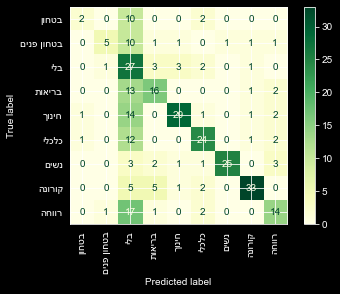

In [43]:
evaluate("-------Logistic Regression simple counts, C=1) Evaluation-------",y_test,logistic_simple_predicted,mat_tags)
get_confused_samples(quotes,logistic_simple_predicted)

-------Logistic Regression simple counts, C=2) Evaluation-------
Micro:
precision: 0.5765472312703583
recall: 0.5765472312703583
f1: 0.5765472312703583

Macro:
precision: 0.6787030249878547
recall: 0.5283176810350724
f1: 0.5601415178455843

Accuracy: 0.5765472312703583

Confusion Matrix:

--------- confusion analysis----------
misclassified as no topic: 83 of 130 (63.84615384615384%)

Distribution of misclassified topics:
בלי           83
בריאות        12
רווחה         10
כלכלי          9
חינוך          6
קורונה         5
בטחון          2
בטחון פנים     2
נשים           1
Name: predicted, dtype: int64


,index,QuoteText,true,predicted
2,2,תודה רבה לכם שבאתם. אנחנו מתשע בבוקר בכל ועדות...,רווחה,בלי
4,4,דבר נוסף שהגיע גם לפתחה של הוועדה זה שאנשים שח...,קורונה,כלכלי
7,7,שלום רב. בוקר טוב. התכנסנו כאן בהמשך לדיון שקי...,חינוך,בלי
8,8,"אני אומר, גם בהקשר של היום המיוחד הזה שאנחנו מ...",רווחה,בלי
14,14,"בוקר טוב לכולם, ברשותכם אני פותחת את דיון הווע...",קורונה,בריאות
...,...,...,...,...
296,296,האם קיימת באוניברסיטה כל שהיא בארץ דרישת פטור ...,חינוך,בלי
301,301,כולנו נחשפנו בעיקר דרך התקשורת לאבסורד הזה של ...,בטחון פנים,בלי
303,303,"עכשיו, היות וזה תהליך ארוך ומתייחס לתקופות שונ...",בטחון,בלי
304,304,\tאני מאוד מבקש שכולנו היום נתגייס מתוך מטרה א...,חינוך,בלי


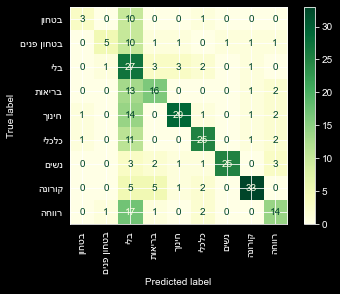

In [44]:
evaluate("-------Logistic Regression simple counts, C=2) Evaluation-------",y_test,logistic_c2_simple_predicted,mat_tags)
get_confused_samples(quotes,logistic_c2_simple_predicted)

-------Logistic Regression simple counts, C=0.5) Evaluation-------
Micro:
precision: 0.5700325732899023
recall: 0.5700325732899023
f1: 0.5700325732899023

Macro:
precision: 0.6866604809539593
recall: 0.5178286205460119
f1: 0.5482813409799633

Accuracy: 0.5700325732899023

Confusion Matrix:

--------- confusion analysis----------
misclassified as no topic: 87 of 132 (65.9090909090909%)

Distribution of misclassified topics:
בלי           87
בריאות        12
רווחה         10
כלכלי          9
חינוך          6
קורונה         4
בטחון פנים     2
בטחון          1
נשים           1
Name: predicted, dtype: int64


,index,QuoteText,true,predicted
2,2,תודה רבה לכם שבאתם. אנחנו מתשע בבוקר בכל ועדות...,רווחה,בלי
4,4,דבר נוסף שהגיע גם לפתחה של הוועדה זה שאנשים שח...,קורונה,כלכלי
7,7,שלום רב. בוקר טוב. התכנסנו כאן בהמשך לדיון שקי...,חינוך,בלי
8,8,"אני אומר, גם בהקשר של היום המיוחד הזה שאנחנו מ...",רווחה,בלי
14,14,"בוקר טוב לכולם, ברשותכם אני פותחת את דיון הווע...",קורונה,בריאות
...,...,...,...,...
300,300,"אז יש מנגנון מעניין שאנחנו המלצנו להגדיל אותו,...",כלכלי,רווחה
301,301,כולנו נחשפנו בעיקר דרך התקשורת לאבסורד הזה של ...,בטחון פנים,בלי
303,303,"עכשיו, היות וזה תהליך ארוך ומתייחס לתקופות שונ...",בטחון,בלי
304,304,\tאני מאוד מבקש שכולנו היום נתגייס מתוך מטרה א...,חינוך,בלי


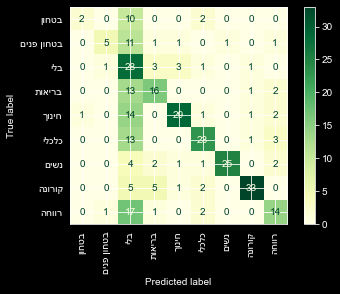

In [45]:
evaluate("-------Logistic Regression simple counts, C=0.5) Evaluation-------",y_test,logistic_c05_simple_predicted,mat_tags)
get_confused_samples(quotes,logistic_c05_simple_predicted)

-------Logistic Regression TFIDF counts, C=1) Evaluation-------
Micro:
precision: 0.5667752442996743
recall: 0.5667752442996743
f1: 0.5667752442996743

Macro:
precision: 0.6767847279443987
recall: 0.5154238866195389
f1: 0.5404470913753421

Accuracy: 0.5667752442996743

Confusion Matrix:

--------- confusion analysis----------
misclassified as no topic: 65 of 133 (48.87218045112782%)

Distribution of misclassified topics:
בלי           65
רווחה         32
בריאות        16
חינוך          6
קורונה         6
כלכלי          5
בטחון          1
נשים           1
בטחון פנים     1
Name: predicted, dtype: int64


,index,QuoteText,true,predicted
2,2,תודה רבה לכם שבאתם. אנחנו מתשע בבוקר בכל ועדות...,רווחה,בלי
4,4,דבר נוסף שהגיע גם לפתחה של הוועדה זה שאנשים שח...,קורונה,בריאות
7,7,שלום רב. בוקר טוב. התכנסנו כאן בהמשך לדיון שקי...,חינוך,בלי
8,8,"אני אומר, גם בהקשר של היום המיוחד הזה שאנחנו מ...",רווחה,בלי
14,14,"בוקר טוב לכולם, ברשותכם אני פותחת את דיון הווע...",קורונה,בריאות
...,...,...,...,...
300,300,"אז יש מנגנון מעניין שאנחנו המלצנו להגדיל אותו,...",כלכלי,רווחה
301,301,כולנו נחשפנו בעיקר דרך התקשורת לאבסורד הזה של ...,בטחון פנים,בלי
303,303,"עכשיו, היות וזה תהליך ארוך ומתייחס לתקופות שונ...",בטחון,בלי
304,304,\tאני מאוד מבקש שכולנו היום נתגייס מתוך מטרה א...,חינוך,בלי


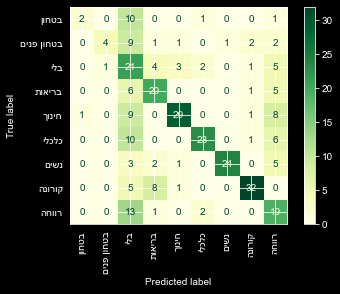

In [46]:
evaluate("-------Logistic Regression TFIDF counts, C=1) Evaluation-------",y_test,logistic_tfidf_predicted,mat_tags)
get_confused_samples(quotes,logistic_tfidf_predicted)

-------Logistic Regression TFIDF counts, C=0.5) Evaluation-------
Micro:
precision: 0.5504885993485342
recall: 0.5504885993485342
f1: 0.5504885993485342

Macro:
precision: 0.7412061403508772
recall: 0.4897169296625818
f1: 0.5080642505753578

Accuracy: 0.5504885993485342

Confusion Matrix:

--------- confusion analysis----------
misclassified as no topic: 77 of 138 (55.79710144927537%)

Distribution of misclassified topics:
בלי       77
רווחה     31
בריאות    13
חינוך      6
קורונה     6
כלכלי      4
נשים       1
Name: predicted, dtype: int64


,index,QuoteText,true,predicted
2,2,תודה רבה לכם שבאתם. אנחנו מתשע בבוקר בכל ועדות...,רווחה,בלי
4,4,דבר נוסף שהגיע גם לפתחה של הוועדה זה שאנשים שח...,קורונה,רווחה
7,7,שלום רב. בוקר טוב. התכנסנו כאן בהמשך לדיון שקי...,חינוך,בלי
8,8,"אני אומר, גם בהקשר של היום המיוחד הזה שאנחנו מ...",רווחה,בלי
14,14,"בוקר טוב לכולם, ברשותכם אני פותחת את דיון הווע...",קורונה,בריאות
...,...,...,...,...
300,300,"אז יש מנגנון מעניין שאנחנו המלצנו להגדיל אותו,...",כלכלי,רווחה
301,301,כולנו נחשפנו בעיקר דרך התקשורת לאבסורד הזה של ...,בטחון פנים,בלי
303,303,"עכשיו, היות וזה תהליך ארוך ומתייחס לתקופות שונ...",בטחון,בלי
304,304,\tאני מאוד מבקש שכולנו היום נתגייס מתוך מטרה א...,חינוך,בלי


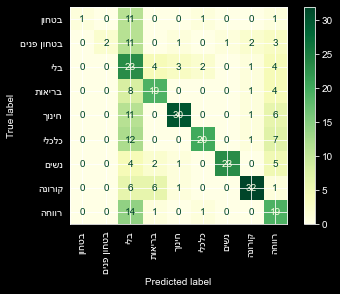

In [47]:
evaluate("-------Logistic Regression TFIDF counts, C=0.5) Evaluation-------",y_test,logistic_c05_tfidf_predicted,mat_tags)
get_confused_samples(quotes,logistic_c05_tfidf_predicted)

## Random forest

-----Random forest with simple counts, 100 trees, max depth 200) Evaluation-----
Micro:
precision: 0.5830618892508144
recall: 0.5830618892508144
f1: 0.5830618892508144

Macro:
precision: 0.7411862994297335
recall: 0.5358856138747443
f1: 0.5728675538774993

Accuracy: 0.5830618892508144

Confusion Matrix:

--------- confusion analysis----------
misclassified as no topic: 95 of 128 (74.21875%)

Distribution of misclassified topics:
בלי           95
בריאות        12
חינוך          7
קורונה         5
רווחה          2
בטחון          2
נשים           2
כלכלי          2
בטחון פנים     1
Name: predicted, dtype: int64


,index,QuoteText,true,predicted
2,2,תודה רבה לכם שבאתם. אנחנו מתשע בבוקר בכל ועדות...,רווחה,בלי
4,4,דבר נוסף שהגיע גם לפתחה של הוועדה זה שאנשים שח...,קורונה,בלי
8,8,"אני אומר, גם בהקשר של היום המיוחד הזה שאנחנו מ...",רווחה,בלי
12,12,"אני פותח את ישיבת ועדת החוקה, חוק ומשפט בנושא:...",כלכלי,בלי
14,14,"בוקר טוב לכולם, ברשותכם אני פותחת את דיון הווע...",קורונה,בריאות
...,...,...,...,...
300,300,"אז יש מנגנון מעניין שאנחנו המלצנו להגדיל אותו,...",כלכלי,בלי
301,301,כולנו נחשפנו בעיקר דרך התקשורת לאבסורד הזה של ...,בטחון פנים,בלי
303,303,"עכשיו, היות וזה תהליך ארוך ומתייחס לתקופות שונ...",בטחון,בלי
304,304,\tאני מאוד מבקש שכולנו היום נתגייס מתוך מטרה א...,חינוך,בלי


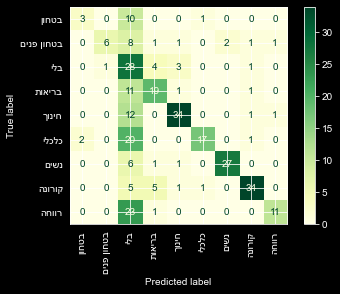

In [48]:
evaluate("-----Random forest with simple counts, 100 trees, max depth 200) Evaluation-----",y_test,forest_100_200_simple_predicted,mat_tags)
get_confused_samples(quotes,forest_100_200_simple_predicted)

-----Random forest with simple counts, 100 trees, max depth 1000) Evaluation-----
Micro:
precision: 0.5374592833876222
recall: 0.5374592833876222
f1: 0.5374592833876222

Macro:
precision: 0.7615553444500813
recall: 0.49411060905626125
f1: 0.5362456327769665

Accuracy: 0.5374592833876222

Confusion Matrix:

--------- confusion analysis----------
misclassified as no topic: 114 of 142 (80.28169014084507%)

Distribution of misclassified topics:
בלי           114
בריאות         11
חינוך           6
קורונה          5
רווחה           3
נשים            1
בטחון פנים      1
בטחון           1
Name: predicted, dtype: int64


,index,QuoteText,true,predicted
2,2,תודה רבה לכם שבאתם. אנחנו מתשע בבוקר בכל ועדות...,רווחה,בלי
4,4,דבר נוסף שהגיע גם לפתחה של הוועדה זה שאנשים שח...,קורונה,בלי
7,7,שלום רב. בוקר טוב. התכנסנו כאן בהמשך לדיון שקי...,חינוך,בלי
8,8,"אני אומר, גם בהקשר של היום המיוחד הזה שאנחנו מ...",רווחה,בלי
14,14,"בוקר טוב לכולם, ברשותכם אני פותחת את דיון הווע...",קורונה,בריאות
...,...,...,...,...
300,300,"אז יש מנגנון מעניין שאנחנו המלצנו להגדיל אותו,...",כלכלי,בלי
301,301,כולנו נחשפנו בעיקר דרך התקשורת לאבסורד הזה של ...,בטחון פנים,בלי
303,303,"עכשיו, היות וזה תהליך ארוך ומתייחס לתקופות שונ...",בטחון,בלי
304,304,\tאני מאוד מבקש שכולנו היום נתגייס מתוך מטרה א...,חינוך,בלי


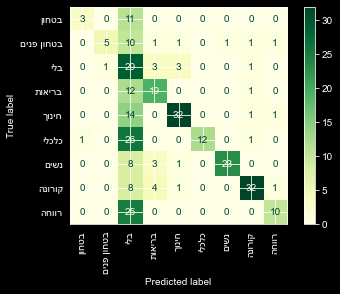

In [49]:
evaluate("-----Random forest with simple counts, 100 trees, max depth 1000) Evaluation-----",y_test,forest_100_1000_simple_predicted,mat_tags)
get_confused_samples(quotes,forest_100_1000_simple_predicted)

-----Random forest with simple counts, 150 trees, max depth 1000) Evaluation-----
Micro:
precision: 0.5309446254071661
recall: 0.5309446254071661
f1: 0.5309446254071661

Macro:
precision: 0.7258459751985125
recall: 0.4872385584342106
f1: 0.5234957674691512

Accuracy: 0.5309446254071661

Confusion Matrix:

--------- confusion analysis----------
misclassified as no topic: 110 of 144 (76.38888888888889%)

Distribution of misclassified topics:
בלי           110
בריאות         16
חינוך           6
קורונה          5
בטחון           3
רווחה           2
נשים            1
בטחון פנים      1
Name: predicted, dtype: int64


,index,QuoteText,true,predicted
2,2,תודה רבה לכם שבאתם. אנחנו מתשע בבוקר בכל ועדות...,רווחה,בלי
4,4,דבר נוסף שהגיע גם לפתחה של הוועדה זה שאנשים שח...,קורונה,בלי
7,7,שלום רב. בוקר טוב. התכנסנו כאן בהמשך לדיון שקי...,חינוך,בלי
8,8,"אני אומר, גם בהקשר של היום המיוחד הזה שאנחנו מ...",רווחה,בלי
14,14,"בוקר טוב לכולם, ברשותכם אני פותחת את דיון הווע...",קורונה,בריאות
...,...,...,...,...
300,300,"אז יש מנגנון מעניין שאנחנו המלצנו להגדיל אותו,...",כלכלי,בלי
301,301,כולנו נחשפנו בעיקר דרך התקשורת לאבסורד הזה של ...,בטחון פנים,בלי
303,303,"עכשיו, היות וזה תהליך ארוך ומתייחס לתקופות שונ...",בטחון,בלי
304,304,\tאני מאוד מבקש שכולנו היום נתגייס מתוך מטרה א...,חינוך,בלי


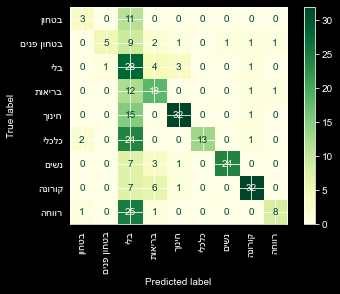

In [50]:
evaluate("-----Random forest with simple counts, 150 trees, max depth 1000) Evaluation-----",y_test,forest_150_1000_simple_predicted,mat_tags)
get_confused_samples(quotes,forest_150_1000_simple_predicted)

-----Random forest with TFIDF counts, 100 trees, max depth 200) Evaluation-----
Micro:
precision: 0.5993485342019544
recall: 0.5993485342019544
f1: 0.5993485342019544

Macro:
precision: 0.7181429971325852
recall: 0.5554010143684056
f1: 0.5880400370122065

Accuracy: 0.5993485342019544

Confusion Matrix:

--------- confusion analysis----------
misclassified as no topic: 79 of 123 (64.22764227642277%)

Distribution of misclassified topics:
בלי           79
בריאות        17
רווחה          8
חינוך          8
קורונה         5
בטחון          2
כלכלי          2
נשים           1
בטחון פנים     1
Name: predicted, dtype: int64


,index,QuoteText,true,predicted
2,2,תודה רבה לכם שבאתם. אנחנו מתשע בבוקר בכל ועדות...,רווחה,בלי
4,4,דבר נוסף שהגיע גם לפתחה של הוועדה זה שאנשים שח...,קורונה,בלי
8,8,"אני אומר, גם בהקשר של היום המיוחד הזה שאנחנו מ...",רווחה,בלי
14,14,"בוקר טוב לכולם, ברשותכם אני פותחת את דיון הווע...",קורונה,בריאות
15,15,"בעצם מה שקורה כרגע, אנחנו גם גילינו שיש בפרוטו...",בלי,רווחה
...,...,...,...,...
300,300,"אז יש מנגנון מעניין שאנחנו המלצנו להגדיל אותו,...",כלכלי,רווחה
301,301,כולנו נחשפנו בעיקר דרך התקשורת לאבסורד הזה של ...,בטחון פנים,בלי
303,303,"עכשיו, היות וזה תהליך ארוך ומתייחס לתקופות שונ...",בטחון,בלי
304,304,\tאני מאוד מבקש שכולנו היום נתגייס מתוך מטרה א...,חינוך,בלי


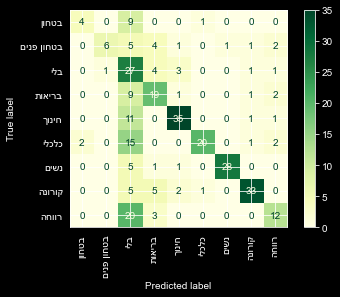

In [51]:
evaluate("-----Random forest with TFIDF counts, 100 trees, max depth 200) Evaluation-----",y_test,forest_100_200_tfidf_predicted,mat_tags)
get_confused_samples(quotes,forest_100_200_tfidf_predicted)

-----Random forest with TFIDF counts, 100 trees, max depth 1000) Evaluation-----
Micro:
precision: 0.5570032573289903
recall: 0.5570032573289903
f1: 0.5570032573289903

Macro:
precision: 0.7547611252058885
recall: 0.5131975531432054
f1: 0.5528283311292363

Accuracy: 0.5570032573289903

Confusion Matrix:

--------- confusion analysis----------
misclassified as no topic: 104 of 136 (76.47058823529412%)

Distribution of misclassified topics:
בלי           104
בריאות         15
חינוך           7
קורונה          5
בטחון           2
רווחה           1
נשים            1
בטחון פנים      1
Name: predicted, dtype: int64


,index,QuoteText,true,predicted
2,2,תודה רבה לכם שבאתם. אנחנו מתשע בבוקר בכל ועדות...,רווחה,בלי
4,4,דבר נוסף שהגיע גם לפתחה של הוועדה זה שאנשים שח...,קורונה,בלי
8,8,"אני אומר, גם בהקשר של היום המיוחד הזה שאנחנו מ...",רווחה,בלי
14,14,"בוקר טוב לכולם, ברשותכם אני פותחת את דיון הווע...",קורונה,בריאות
19,19,בירושלים אנחנו ראינו מהלך משמעותי. לפני כמה שנ...,רווחה,בלי
...,...,...,...,...
300,300,"אז יש מנגנון מעניין שאנחנו המלצנו להגדיל אותו,...",כלכלי,בלי
301,301,כולנו נחשפנו בעיקר דרך התקשורת לאבסורד הזה של ...,בטחון פנים,בלי
303,303,"עכשיו, היות וזה תהליך ארוך ומתייחס לתקופות שונ...",בטחון,בלי
304,304,\tאני מאוד מבקש שכולנו היום נתגייס מתוך מטרה א...,חינוך,בלי


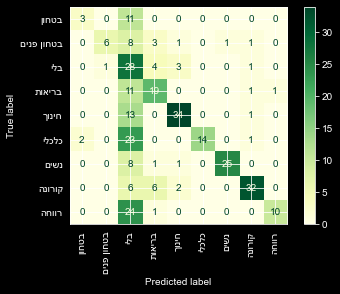

In [52]:
evaluate("-----Random forest with TFIDF counts, 100 trees, max depth 1000) Evaluation-----",y_test,forest_100_1000_tfidf_predicted,mat_tags)
get_confused_samples(quotes,forest_100_1000_tfidf_predicted)

## SVM

-----SVM with simple counts Evaluation-----
Micro:
precision: 0.41042345276872966
recall: 0.41042345276872966
f1: 0.4104234527687296

Macro:
precision: 0.6936965811965812
recall: 0.3530477294064251
f1: 0.37622848119624236

Accuracy: 0.41042345276872966

Confusion Matrix:

--------- confusion analysis----------
misclassified as no topic: 163 of 181 (90.05524861878453%)

Distribution of misclassified topics:
בלי       163
רווחה       9
חינוך       5
קורונה      2
בטחון       1
בריאות      1
Name: predicted, dtype: int64


,index,QuoteText,true,predicted
2,2,תודה רבה לכם שבאתם. אנחנו מתשע בבוקר בכל ועדות...,רווחה,בלי
3,3,"לגבי תשלומי הורים, גם פה אני חייב להגיד: הוועד...",חינוך,בלי
4,4,דבר נוסף שהגיע גם לפתחה של הוועדה זה שאנשים שח...,קורונה,בלי
7,7,שלום רב. בוקר טוב. התכנסנו כאן בהמשך לדיון שקי...,חינוך,בלי
8,8,"אני אומר, גם בהקשר של היום המיוחד הזה שאנחנו מ...",רווחה,בלי
...,...,...,...,...
300,300,"אז יש מנגנון מעניין שאנחנו המלצנו להגדיל אותו,...",כלכלי,בלי
301,301,כולנו נחשפנו בעיקר דרך התקשורת לאבסורד הזה של ...,בטחון פנים,בלי
303,303,"עכשיו, היות וזה תהליך ארוך ומתייחס לתקופות שונ...",בטחון,בלי
304,304,\tאני מאוד מבקש שכולנו היום נתגייס מתוך מטרה א...,חינוך,בלי


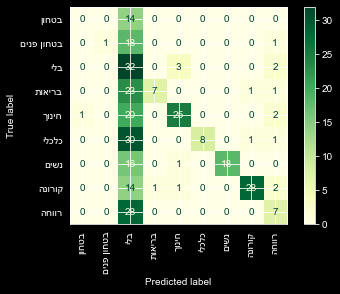

In [53]:
evaluate("-----SVM with simple counts Evaluation-----",y_test, svm_simple_predicted,mat_tags)
get_confused_samples(quotes,svm_simple_predicted)

-----SVM with TFIDF counts Evaluation-----
Micro:
precision: 0.49185667752442996
recall: 0.49185667752442996
f1: 0.49185667752442996

Macro:
precision: 0.723264284448495
recall: 0.4351541370563109
f1: 0.46633796959883916

Accuracy: 0.49185667752442996

Confusion Matrix:

--------- confusion analysis----------
misclassified as no topic: 138 of 156 (88.46153846153845%)

Distribution of misclassified topics:
בלי       138
בריאות      7
חינוך       6
קורונה      2
בטחון       1
רווחה       1
נשים        1
Name: predicted, dtype: int64


,index,QuoteText,true,predicted
2,2,תודה רבה לכם שבאתם. אנחנו מתשע בבוקר בכל ועדות...,רווחה,בלי
4,4,דבר נוסף שהגיע גם לפתחה של הוועדה זה שאנשים שח...,קורונה,בלי
7,7,שלום רב. בוקר טוב. התכנסנו כאן בהמשך לדיון שקי...,חינוך,בלי
8,8,"אני אומר, גם בהקשר של היום המיוחד הזה שאנחנו מ...",רווחה,בלי
12,12,"אני פותח את ישיבת ועדת החוקה, חוק ומשפט בנושא:...",כלכלי,בלי
...,...,...,...,...
300,300,"אז יש מנגנון מעניין שאנחנו המלצנו להגדיל אותו,...",כלכלי,בלי
301,301,כולנו נחשפנו בעיקר דרך התקשורת לאבסורד הזה של ...,בטחון פנים,בלי
303,303,"עכשיו, היות וזה תהליך ארוך ומתייחס לתקופות שונ...",בטחון,בלי
304,304,\tאני מאוד מבקש שכולנו היום נתגייס מתוך מטרה א...,חינוך,בלי


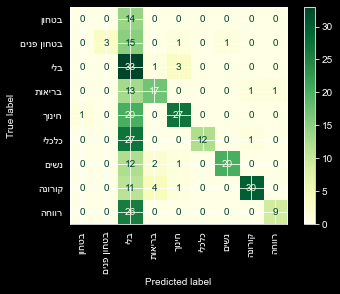

In [54]:
evaluate("-----SVM with TFIDF counts Evaluation-----",y_test, svm_tfidf_predicted,mat_tags)
get_confused_samples(quotes,svm_tfidf_predicted)